# Correcting for Template Changes in ATLAS Light Curves

This notebook takes into account ATLAS's periodic replacement of the difference image reference templates, which may cause step discontinuities in flux. Two template changes have been recorded at MJDs 58417 and 58882. More information can be found here: https://fallingstar-data.com/forcedphot/faq/.

We aid the user in adding offset flux to different regions of the ATLAS light curve in order to correct for these step discontinuities.

In order for this notebook to work correctly, the ATLAS light curves must already be downloaded and saved. Each light curve must also only include measurements for a single filter. To download SN and control light curves, please refer to the documentation `README.md` and use the download script `download_atlas_lc.py`.

## Settings

<div class="alert alert-block alert-info">
    <b>Tip:</b> Edit the following settings to correspond to your target SN and source directory for data.
</div>


Below we have set example fields for SN 2018gkr. Recommended fields to change at a minimum include `tnsname`, `source_dir`, and `discovery_date`.

In [1]:
##### LOADING THE SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2023ixf'

# Enter the path to the data directory that contains the SN directories:
source_dir = f'/Users/sofiarest/Desktop/Supernovae/data/temp2' 

# Enter the path to a directory to optionally save any plots:
output_dir = f'{source_dir}/{tnsname}/plots'

# Enter the filter for this light curve (must be 'o' or 'c'):
filt = 'o'

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
discovery_date = 60063.727257
api_key = None
tns_id = None
bot_name = None

##### LOADING CONTROL LIGHT CURVES #####

# Set to True if you are planning on applying the control light curve cut 
# and have already downloaded the control light curves:
load_controls = True

# Enter the number of control light curves to load:
n_controls = 16

# Enter the source directory of the control light curve files:
controls_dir = f'{source_dir}/{tnsname}/controls'

##### PLOTTING #####

# If True, try to calculate the best y limits automatically for each plot;
# if False, leave y limits to matplotlib 
auto_xylimits = True

## Miscellaneous functions (skip this section)

In [2]:
import sys, os
sys.path.insert(1,'../')
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB
from clean_atlas_lc_v2 import CleanAtlasLightCurve
import numpy as np
from copy import deepcopy
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
# plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.rc('legend', fontsize = 10)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['axes.linewidth'] = 1
marker_size = 30
marker_edgewidth = 1.5
sn_flux = 'orange' if filt == 'o' else 'cyan'
sn_flagged_flux = 'red' 
ctrl_flux = 'steelblue'

# ATLAS template change dates (MJD)
tchange1 = 58417
tchange2 = 58882

def do_manual_xylimits(limits):
    for limit in limits:
        if not limit is None:
            return True
    return False

def set_xylimits(lc, limits, control_index=0, indices=None):
    if auto_xylimits:
        if limits[0] is None:
            limits[0] = lc.lcs[control_index].t['MJD'].min() * 0.999
        if limits[1] is None:
            limits[1] = lc.lcs[control_index].t['MJD'].max() * 1.001
        
        if indices is None:
            indices = lc.get_ix()
        # exclude measurements with duJy > 160
        good_ix = lc.lcs[control_index].ix_inrange(colnames='duJy', uplim=160, indices=indices)
        # get 5% of abs(max flux - min flux)
        flux_min = lc.lcs[control_index].t.loc[good_ix, 'uJy'].min()
        flux_max = lc.lcs[control_index].t.loc[good_ix, 'uJy'].max()
        diff = abs(flux_max - flux_min)
        offset = 0.05 * diff

        if limits[2] is None: 
            limits[2] = flux_min - offset
        if limits[3] is None:
            limits[3] = flux_max + offset

        return limits
    
    if do_manual_xylimits(limits):
        return limits
    
    return None

# 3-panel plot of (1) template regions in different colors and (2) zoom-in on transitions
def plot_template_correction(lc, limits=None, title=None):
	colors = ['salmon', 'sandybrown', 'darkseagreen']
	
	t1, t2 = 58417, 58882
	region1_ix = lc.lcs[0].ix_inrange('MJD', uplim=t1)
	region2_ix = lc.lcs[0].ix_inrange('MJD', lowlim=t1, uplim=t2)
	region3_ix = lc.lcs[0].ix_inrange('MJD', lowlim=t2)

	region1_mean = lc._get_mean(region1_ix[-40:]) # last 40 measurements before t1
	region2a_mean = lc._get_mean(region2_ix[:40]) # first 40 measurements after t1
	region2b_mean = lc._get_mean(region2_ix[-40:]) # last 40 measurements before t2
	region3_mean = lc._get_mean(region3_ix[:40]) # first 40 measurements after t2

	gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.35, wspace=0.4)
	fig = plt.figure()
	fig.set_figwidth(6)
	fig.set_figheight(6)
	fig.tight_layout()

	ax1 = plt.subplot(gs[0, :])
	if not title is None:
		ax1.set_title(title)
	ax1.axvline(x=t1, color='k', linestyle='dotted', label='ATLAS template change', zorder=100)
	ax1.axvline(x=t2, color='k', linestyle='dotted', zorder=100)
	ax1.axhline(color='k',zorder=0)
	limits = set_xylimits(lc, limits)
	ax1.set_xlim(limits[0], limits[1])
	ax1.set_ylim(limits[2], limits[3])

	ax1.errorbar(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], yerr=lc.lcs[0].t.loc[region1_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[0], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax1.scatter(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[0], marker='o', alpha=0.5, zorder=10, label='Region 1 flux')
	ax1.errorbar(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], yerr=lc.lcs[0].t.loc[region2_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[1], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax1.scatter(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[1], marker='o', alpha=0.5, zorder=10, label='Region 2 flux')
	ax1.errorbar(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], yerr=lc.lcs[0].t.loc[region3_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[2], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax1.scatter(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[2], marker='o', alpha=0.5, zorder=10, label='Region 2 flux')

	ax1.legend(facecolor='white', framealpha=1, loc='upper left',  bbox_to_anchor=(1, 1))

	ax2 = plt.subplot(gs[1, 0])
	ax2.set_title('First template change', fontsize=12)
	ax2.axvline(x=t1, color='k', linestyle='dotted', zorder=100)
	ax2.axhline(color='k',zorder=0)
	ax2.set_xlim(lc.lcs[0].t.loc[region1_ix[-40:][0], 'MJD'], lc.lcs[0].t.loc[region2_ix[:40][-1], 'MJD'])

	ax2.errorbar(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], yerr=lc.lcs[0].t.loc[region1_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[0], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax2.scatter(lc.lcs[0].t.loc[region1_ix,'MJD'], lc.lcs[0].t.loc[region1_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[0], marker='o', alpha=0.5, zorder=10)
	ax2.errorbar(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], yerr=lc.lcs[0].t.loc[region2_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[1], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax2.scatter(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[1], marker='o', alpha=0.5, zorder=10)

	ax2.axhline(y=region1_mean, color=colors[0], linestyle='dashed', label='Region 1 mean')
	ax2.axhline(y=region2a_mean, color=colors[1], linestyle='dashed', label='Region 2 mean')

	limits = set_xylimits(lc, limits, indices=AorB(region1_ix[-40:], region2_ix[:40]))
	ax2.set_ylim(limits[2], limits[3])
	ax2.legend(facecolor='white', framealpha=1)

	ax3 = plt.subplot(gs[1, 1]) 
	ax3.set_title('Second template change', fontsize=12)
	ax3.axvline(x=t2, color='k', linestyle='dotted', zorder=100)
	ax3.axhline(color='k',zorder=0)
	ax3.set_xlim(lc.lcs[0].t.loc[region2_ix[-40:][0], 'MJD'], lc.lcs[0].t.loc[region3_ix[:40][-1], 'MJD'])
	ax3.set_ylim(limits[2], limits[3])

	ax3.errorbar(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], yerr=lc.lcs[0].t.loc[region2_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[1], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax3.scatter(lc.lcs[0].t.loc[region2_ix,'MJD'], lc.lcs[0].t.loc[region2_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[1], marker='o', alpha=0.5, zorder=10)
	ax3.errorbar(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], yerr=lc.lcs[0].t.loc[region3_ix,lc.dflux_colnames[0]], fmt='none', ecolor=colors[2], elinewidth=1, capsize=1.2, c=sn_flux, alpha=0.5, zorder=10)
	ax3.scatter(lc.lcs[0].t.loc[region3_ix,'MJD'], lc.lcs[0].t.loc[region3_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=colors[2], marker='o', alpha=0.5, zorder=10)

	ax3.axhline(y=region2b_mean, color=colors[1], linestyle='dashed', label='Region 2 mean')
	ax3.axhline(y=region3_mean, color=colors[2], linestyle='dashed', label='Region 3 mean')

	limits = set_xylimits(lc, limits, indices=AorB(region2_ix[-40:], region3_ix[:40]))
	ax3.set_ylim(limits[2], limits[3])
	ax3.legend(facecolor='white', framealpha=1)

	for ax in (ax1, ax2, ax3):
		ax.minorticks_on()
		ax.tick_params(direction='in', which='both')
		ax.set_xlabel('MJD')
		ax.set_ylabel('uJy')

	plt.show()

## Load the SN ATLAS light curve

In [3]:
print(f'SN {tnsname}, filter {filt}, {n_controls} control light curves')
if not discovery_date is None:
    print(f'SN discovery date: {discovery_date}')
print(f'Source directory (load SN light curve): {source_dir}/{tnsname}')
if load_controls: 
    print(f'Controls directory (load control light curves): {controls_dir}')
print(f'Output directory (save plots): {output_dir}')

SN 2023ixf, filter o, 16 control light curves
SN discovery date: 60063.727257
Source directory (load SN light curve): /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf
Controls directory (load control light curves): /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf/controls
Output directory (save plots): /Users/sofiarest/Desktop/Supernovae/data/temp2/2023ixf/plots


In [4]:
if filt != 'o' and filt != 'c': 
	raise RuntimeError('Filter must be "o" or "c"!')
lc = CleanAtlasLightCurve(filt, tnsname=tnsname, discdate=discovery_date)

# get discovery date
if lc.discdate is None:
	lc._get_tns_data(tnsname, api_key, tns_id, bot_name)

# load SN and control light curves
lc._load(source_dir, filt, n_controls)

# clear any previous offset
lc._clear_offset()

print(lc)


Loading SN light curve and 16 control light curves...
# Subtracting previous offset...
# Setting current uJy offset to 0...
SN 2023ixf light curve: RA None, Dec None, discovery date 60063.727257 MJD


## Apply template correction

In [7]:
# Optionally, manually enter the x and y limits for the plot:
xlim_lower = None
xlim_upper = None
ylim_lower = -100
ylim_upper = 100

            MJD          m  dm    uJy  duJy  F  err  chi/N         RA       Dec        x        y   maj   min   phi  apfit  mag5sig    Sky             Obs    Mask  uJy_offset   duJy_new
0  57233.262703  18.249822 NaN   23.0    53  o    0   1.82  210.91067  54.31166  2829.21  8517.81  3.57  3.45 -66.1 -0.436    18.44  19.38  02a57233o0013o       0           0  54.107812
1  57233.282702  17.972330 NaN   37.0    66  o    0   1.10  210.91067  54.31166  2814.95  8526.45  3.53  3.35 -63.5 -0.453    18.41  19.29  02a57233o0029o       0           0  66.892865
2  57365.645360  18.944322 NaN   -3.0    32  o    0   0.88  210.91067  54.31166  7592.30  2250.86  4.37  3.89   4.6 -0.435    18.89  20.47  02a57365o0696o  524288           0  33.803185
3  57365.663252  18.396507 NaN -104.0    53  o    0   1.19  210.91067  54.31166  7336.52  1681.11  4.13  3.57   3.5 -0.484    18.19  18.98  02a57365o0723o       0           0  54.107812
4  57386.594331  18.878500 NaN   -5.0    34  o    0   0.89  210.91067 

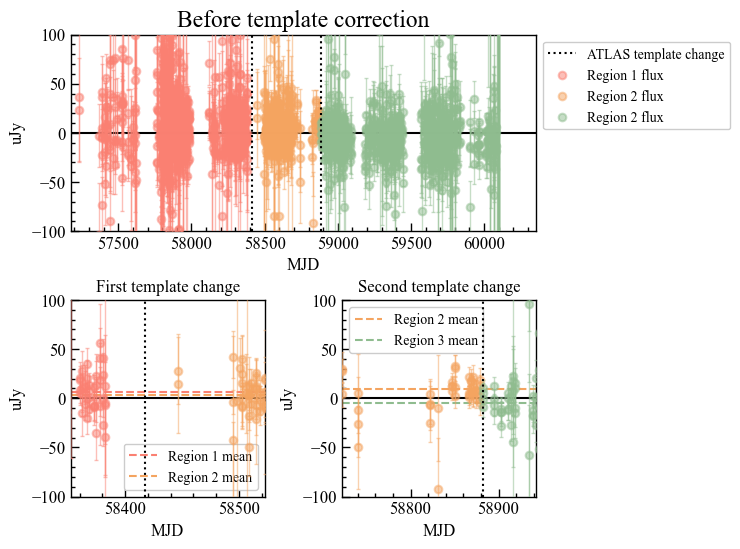

In [8]:
print(lc.lcs[0].t.head().to_string())
limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
plot_template_correction(lc, limits=limits, title='Before template correction')

In [11]:
# Optionally enter flux offsets for each region 
# (set each to None for automatic correction):
global_offset = -5
region1_offset = 0 + global_offset
region2_offset = 0 + global_offset
region3_offset = 10 + global_offset

# Optionally, manually enter the x and y limits for the plot:
xlim_lower = None
xlim_upper = None
ylim_lower = -100
ylim_upper = 100


Correcting light curve flux due to template changes...
# Proceeding with manual template correction...
# Subtracting previous offset...
# Setting current uJy offset to 0...
# Corrective flux -5.00 uJy added to first region
## Recording offset -5.00...
# Corrective flux -5.00 uJy added to second region
## Recording offset -5.00...
# Corrective flux 5.00 uJy added to third region
## Recording offset 5.00...

             MJD    uJy  uJy_offset  duJy
0  57233.262703   18.0          -5    53
1  57233.282702   32.0          -5    66
2  57365.645360   -8.0          -5    32
3  57365.663252 -109.0          -5    53
4  57386.594331  -10.0          -5    34


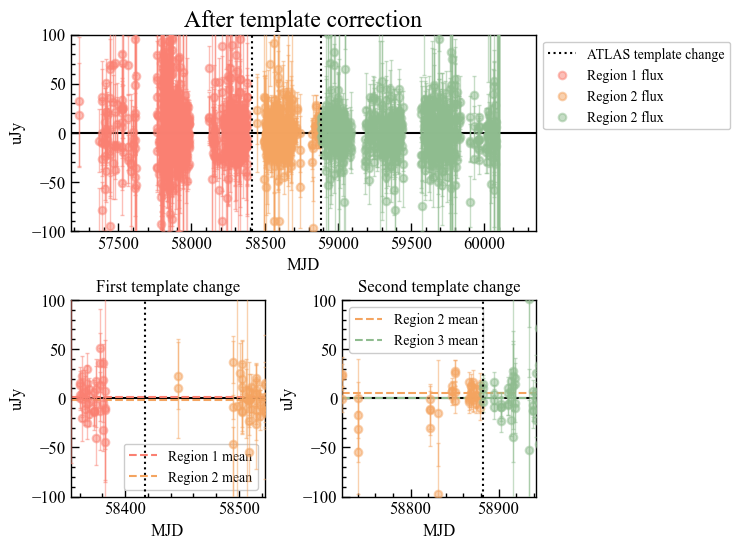

In [12]:
output = lc.template_correction(maskval=0x1|0x2|0x400000|0x800000, 
                                region1_offset=region1_offset, 
                                region2_offset=region2_offset, 
                                region3_offset=region3_offset)
print('\n',lc.lcs[0].t[['MJD','uJy','uJy_offset','duJy']].head().to_string())

limits = [xlim_lower, xlim_upper, ylim_lower, ylim_upper]
plot_template_correction(lc, limits=limits, title='After template correction')

## Optional: save the SN light curve with the new `uJy` and `uJy_offset` columns

In [10]:
# save the SN light curves:
save_lc = True

In [11]:
if save_lc:
    print('Saving light curve with updated uJy and uJy_offset columns...')
    lc._save_lc(source_dir, 0, filt=filt, overwrite=True)

Saving light curve with updated uJy and uJy_offset columns...
